# Bootstrapping

The confidence intervals calculated with the uncertain fit parameters determined using ```scipy.optimize.curve_fit``` or ```lmfit.fit``` are symmetrical. We get $\pm$ some value as the standard deviation. This is a perfectly good was to estimate the confidence interval (all errors are estimated) but it hides a subtle truth. The confidence is not symmetrical. The data does not bnecesssarity have the same contribution to each parameter across the range of measuremnts and some regions may have more error than others, especially with non-linear curve fits.

One way to estimate a confidence interval that reflects these regional effects in your data series is to use bootstrapping. It is a computationally expensive method where we randomly select data points from our data set and perfomr the curve fit hundreds, perhaps thousands of times. Then we values for the parameters that encompass the 68%, 95% and 99% percentiles ($1\sigma$, $2\sigma$, $3\sigma$) or any arbitrary range we like. The median values and these upper and lower bounds will reflect a more accurate picture of estimated error, if we have enough data.

This method may not be useful with small data sets as there may not be enough combinations such that percentiles are meaningful. Choosing the 95% percentile range from 6 values is not useful. However, there are ways to magnify the amount of data through applying random error to data points. Is that appropriate? Some say yes, some say no but at least you will know exactly what I did to determine the confidence interval fopr my experiment because the code is available for your inspection.

## Setup

As before, we load in the *Python* packages needed and set global variables.

In [2]:
### Install and load packages
# 
# #!pip install uncertainties              # uncomment to install dependancy

from scipy.optimize import curve_fit     # tool for curve fitting
from scipy.stats import linregress     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy but use a shorter name, "np"
from matplotlib import pyplot as plt     # tools for plotting
import pandas as pd

import uncertainties as un               # tool set for handling numbers with uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy that uses uncertainty values

### Set global variables

location_data = "../data/"                   ## Use either local folde or github folder. use github locations for Colab
location_styles = "../styles/"
#location_data = "https://raw.githubusercontent.com/blinkletter/StealThisCode/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/StealThisCode/main/styles/"


## The Data Set

We will begin with the 5-point data set that we have been using so far.

In [3]:
temp =     [293, 298,  303,  308,  313]       # list of temperatures
k_obs =    [7.6, 11.7, 15.2, 21.3, 27.8]      # list of observe rate constants (s^-1)
k_obs_err= [0.2, 0.3,  0.1,  0.9,  0.9]       # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)

temp = np.array(temp)              # an array of float values
k = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculate x, y values and the uncertainty y_err using the
###   error propagation provided by the *uncertainties* package

x = 1/temp                         # 1/T
y_u = unp.log(k/temp)              # ln(k/T) uncertain array for y-axis

### Separate the uncertain y value into y and y_err for use in the curve_fit function

y = unp.nominal_values(y_u)        # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)          #   because curve_fit can't handle ufloats

#display(x, k, y_u)

## A Quick Bootstrap

We can get a bootstrapped confidence interval using the ```seaborn.regplot()``` function that is part of the *Seaborn* plotting package. It will perform a bootstrap analysis and plot the confidence interval requested (below I am using a stardard 95% confiodence interval. Change the confidence and see what happens.)

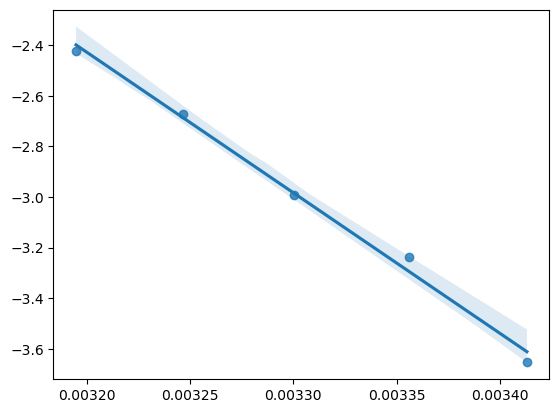

In [4]:
import seaborn as sns
plt.rcdefaults()

sns.regplot(x = x, y = y, ci = 95.0)

plt.show()


### Styling the Plot

Below is the same plot as above but I have added styling to the plot to fit with my own preferred publication style. We can send plotting style parameters into the ```regplot()``` function using keyword dictionaries.

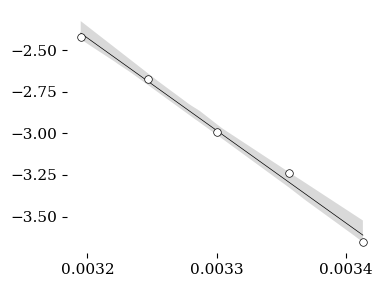

In [5]:
import seaborn as sns
plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

sns.regplot(x = x, y = y,
            scatter_kws = {"facecolor": "white", "edgecolor": "black", "s": 30, "linewidths":0.5, "alpha": 1, "zorder":3},
            line_kws = {"color": "black", "linewidth":0.5, "zorder":2}, 
            ci = 95.0, # 99% level
            )
plt.xticks([0.0032,0.0033,0.0034])   # Set values to display on x-axis

plt.savefig("plots/seaborn1.pdf")
plt.show()

Confidence level = 68%

slope range is -5161.6 to -5757.1
median slope in bootstrap population is -5591.2 + 429.5 - 165.9
best fit value for slope is -5545.9  +/- 277.8

intercept range is 16.00 to 14.07
median intercept in bootstrap population is 15.47 + 0.53 - 1.40
best fit value for intercept is 15.31 +/- 0.92



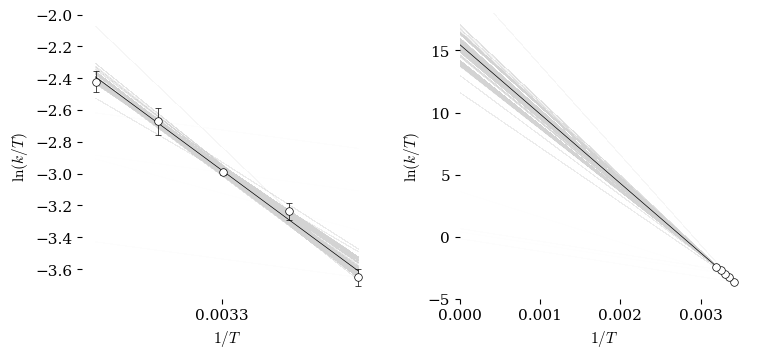

In [6]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 68

#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

## Plot in range of data

slope_list = []
intercept_list = []

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples, 
             #             sigma = y_err_samples, absolute_sigma=False  # Include st_devs for y data in calculations
                     )
    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()


xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_96620/3551955097.py:55: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_samples, y_samples)


Confidence level = 68%

slope range is -5161.6 to -5757.1
median slope in bootstrap population is -5579.6 + 418.0 - 177.4
best fit value for slope is -5545.9  +/- 277.8

intercept range is 16.00 to 14.07
median intercept in bootstrap population is 15.43 + 0.57 - 1.36
best fit value for intercept is 15.31 +/- 0.92



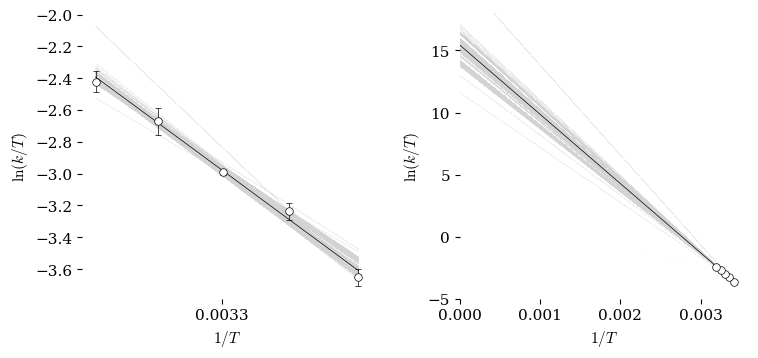

In [6]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 68

#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

## Plot in range of data

slope_list = []
intercept_list = []

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]


    popt,pcov = curve_fit(linear, x_samples, y_samples)

    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()


xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


In [72]:
################################################################################
### BOOTSTRAP WITH AREA CONFIDENCE INTERVAL
### 
### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
################################################################################

sigma = 1                 # Confidence. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
boot_n = 2000             # Number of bootstrap resamples

sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

conf = sigma_dict[sigma]
low_p = 50 - conf/2
high_p = 50 + conf/2

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

#######################################
## Bootstrap - Calculate a list of line fits for resampled data sets.
#######################################

slope_list = []               # A list of slopes from each iteration of bootstrap
intercept_list = []           # A list of intercepts

dS_list = []
dH_list = []

x_for_ci = np.linspace(np.min(x), np.max(x), 100)   # Array of x values 
xb_for_ci = np.linspace(0, np.max(x), 100)          # Array of x values starting at zero

y_list = []                   # A list of predicted values at each data point
y_for_ci = []                 # A list of sets of predicted values at each x point                     
yb_for_ci = []                # A list of sets of predicted values at each xb point

for i in range(0, boot_n):
    pick = np.random.choice(range(0, len(y)), len(y))     # Random list of data points to pick

    x_s = x[pick]             # Get x and y values from random pick
    y_s = y[pick] 
    y_err_s = y_err[pick]

    popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data

    [slope, intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    dH, dS = eyring_calc(slope, intercept)
    dH_list.append(dH)
    dS_list.append(dS)

    y_list.append(linear(x, *popt))            # Predict y at data points and add to list
    y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range and add to list
    yb_for_ci.append(linear(xb_for_ci, *popt)) # Predict y from zero to data range and add to list

# Convert these lists of arrays to arrays of arrays (a matrix)
y_list = np.array(y_list)
y_for_ci = np.array(y_for_ci)    
yb_for_ci = np.array(yb_for_ci)

#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,                        # Final curve fit of original data
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

# Create new ufloat objects from returned parameters and covariance matrix results
[slope_u, intercept_u] = un.correlated_values(popt, pcov)

[slope,intercept] = unp.nominal_values([slope_u, intercept_u])
[slope_err, int_err] = unp.std_devs([slope_u, intercept_u])

#######################################
### Report
#######################################
numbers = unp.nominal_values(slope_list)
top_slope = np.percentile(numbers, high_p)
bot_slope = np.percentile(numbers, low_p)
median_slope = np.percentile(numbers, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope_u:0.1f}")
print()

numbers = unp.nominal_values(intercept_list)
top_intercept = np.percentile(numbers, high_p)
bot_intercept = np.percentile(numbers, low_p)
median_intercept = np.percentile(numbers, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept_u:0.2f}")
print()

dH, dS = eyring_calc(slope_u, intercept_u)

numbers = unp.nominal_values(dH_list)
top_dH = np.percentile(numbers, high_p)
bot_dH = np.percentile(numbers, low_p)
median_dH = np.percentile(numbers, 50)

print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
print(f"median delta H in bootstrap population is {median_dH:0.2f} + {top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}")
print(f"best fit value for delta H is {dH:0.2f}")
print()

numbers = unp.nominal_values(dS_list)
top_dS = np.percentile(numbers, high_p)
bot_dS = np.percentile(numbers, low_p)
median_dS = np.percentile(numbers, 50)

print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
print(f"median delta S in bootstrap population is {median_dS:0.2f} + {top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
print(f"best fit value for delta S is {dS:0.2f}")
print()


Confidence level = 68.3%

slope range is -5158.7 to -5757.1
median slope in bootstrap population is -5579.6 + 421.0 - 177.4
best fit value for slope is -5545.9+/-277.8

intercept range is 16.00 to 14.06
median intercept in bootstrap population is 15.43 + 0.57 - 1.38
best fit value for intercept is 15.31+/-0.92

delta H range is 42891.52 to 47866.87
median delta H in bootstrap population is 46391.72 + 1475.15 - 3500.20
best fit value for delta H is 46110.87+/-2309.56

delta S range is -80.67 to -64.51
median delta S in bootstrap population is -69.22 + 4.71 - 11.45
best fit value for delta S is -70.24+/-7.63



## Plotting the Bootstrap Runs

Let us plot all the curve fits fom the bootstrap. Thats 2000 lines on a plot. I will use transparent lines (5% visible or alpha = 0.05) so that only the areas of the plot with many lines will "stack up" and be visible. The code below will plot the bootstrap data.

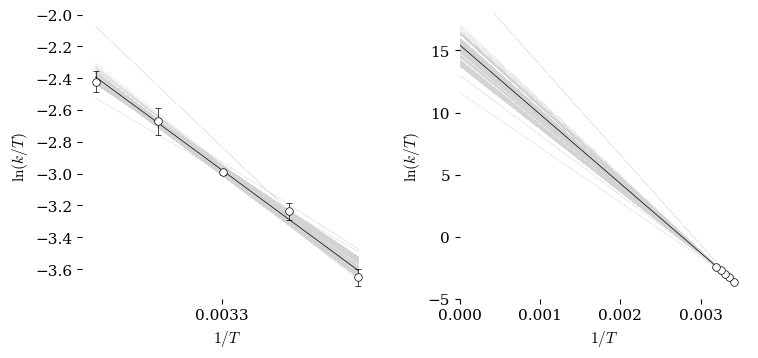

-2.4318621564828646

slope range is -2.432 to -2.477
median slope in bootstrap population is -2.464 + 0.032 - 0.013


In [73]:

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)

for line in y_for_ci:
    ax[0].plot(x_for_ci, line, color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
for line in yb_for_ci:
    ax[1].plot(xb_for_ci, line, color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)

#######################################
### Plot Best Fit
#######################################
xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

ax[0].fill_between(x_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(xb_for_ci)):
    top_y.append(np.percentile(yb_for_ci[:,n], high_p))
    bot_y.append(np.percentile(yb_for_ci[:,n], low_p))
    med_y.append(np.percentile(yb_for_ci[:,n], 50))

ax[1].fill_between(xb_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")


#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


yb_for_ci = np.array(yb_for_ci)
y_for_ci = np.array(y_for_ci)

n=5
aa = y_for_ci[:,n]
#display(aa)

top_slope = np.percentile(aa, high_p)
bot_slope = np.percentile(aa, low_p)
median_slope = np.percentile(aa, 50)

display(top_slope)

print(f"slope range is {top_slope:0.3f} to {bot_slope:0.3f}")
print(f"median slope in bootstrap population is {median_slope:0.3f} + {top_slope-median_slope:0.3f} - {median_slope-bot_slope:0.3f}")

################################################################################
################################################################################
################################################################################
################################################################################


/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_96620/2097192312.py:70: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_samples, y_samples)


Confidence level = 68%

slope range is -5163.8 to -5880.8
median slope in bootstrap population is -5566.3 + 402.6 - 314.5
best fit value for slope is -5545.9  +/- 277.8

intercept range is 16.43 to 14.08
median intercept in bootstrap population is 15.38 + 1.05 - 1.30
best fit value for intercept is 15.31 +/- 0.92



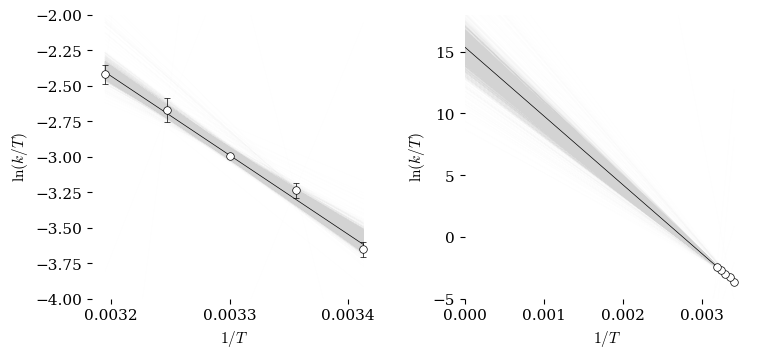

-2.4231367073199843

slope range is -2.423 to -2.490
median slope in bootstrap population is -2.462 + 0.039 - 0.028


In [92]:
################################################################################
### SMOOTHED BOOTSTRAP
################################################################################
################################################################################

## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 68

low_p = 50 - conf/2
high_p = 50 + conf/2



#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
          ylim=[-4.0,-2.0]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

#######################################
## Bootstrap with plots
#######################################

slope_list = []
intercept_list = []
y_list = []
x_for_ci = np.linspace(np.min(x), np.max(x), 100)
xb_for_ci = np.linspace(0, np.max(x), 100)
y_for_ci = []
yb_for_ci = []
for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = np.random.normal(y[sample_index], y_err[sample_index])   ### smooth with gaussian error
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples)

    y_list.append(linear(x, *popt))
    y_for_ci.append(linear(x_for_ci, *popt))
    yb_for_ci.append(linear(xb_for_ci, *popt))

    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
y_for_ci = np.array(y_for_ci)
yb_for_ci = np.array(yb_for_ci)
y_list = np.array(y_list)


#xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


#######################################
### Report
#######################################
top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()

#######################################
### Plot Best Fit
#######################################
xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

ax[0].set_xticks([0.0032,0.0033,0.0034])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

#ax[0].fill_between(x_for_ci, top_y, bot_y, facecolor="lightgray", alpha=0.4, zorder = 0)

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(xb_for_ci)):
    top_y.append(np.percentile(yb_for_ci[:,n], high_p))
    bot_y.append(np.percentile(yb_for_ci[:,n], low_p))
    med_y.append(np.percentile(yb_for_ci[:,n], 50))

ax[1].fill_between(xb_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")


#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


yb_for_ci = np.array(yb_for_ci)
y_for_ci = np.array(y_for_ci)

n=5
aa = y_for_ci[:,n]
#display(aa)

top_slope = np.percentile(aa, high_p)
bot_slope = np.percentile(aa, low_p)
median_slope = np.percentile(aa, 50)

display(top_slope)

print(f"slope range is {top_slope:0.3f} to {bot_slope:0.3f}")
print(f"median slope in bootstrap population is {median_slope:0.3f} + {top_slope-median_slope:0.3f} - {median_slope-bot_slope:0.3f}")

################################################################################
################################################################################
################################################################################
################################################################################


In [85]:
np.random.normal(y[sample_index], y_err[sample_index]), print(sample_index)

[2 2 3 0 1]


(array([-2.99239249, -2.99035646, -2.64330726, -3.65388745, -3.22586165]),
 None)